In [1]:
from keras.layers import *
from keras.models import *
from keras.optimizers import *

import os
import cv2
import numpy as np
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

from keras.backend.tensorflow_backend import set_session
import tensorflow as tf

config = tf.ConfigProto()
config.gpu_options.allow_growth=True
set_session(tf.Session(config=config))

Using TensorFlow backend.


In [2]:
df = pd.read_csv('../record2/driving_log.csv')
df.columns = ['center', 'left', 'right', 'dir', 'acc', 'nacc', 'speed']
print df['speed'].mean(), df['dir'].mean(), df['dir'].max(), df['dir'].min(), (df['dir'] > 0).mean()
df.head()

30.1862095825 -0.0341659077352 0.6451206 -0.8423467 0.113258600696


,center,left,right,dir,acc,nacc,speed
0,/home/ypw/Desktop/record2/IMG/center_2017_10_1...,/home/ypw/Desktop/record2/IMG/left_2017_10_19_...,/home/ypw/Desktop/record2/IMG/right_2017_10_19...,0.000000,1,0,30.19050
1,/home/ypw/Desktop/record2/IMG/center_2017_10_1...,/home/ypw/Desktop/record2/IMG/left_2017_10_19_...,/home/ypw/Desktop/record2/IMG/right_2017_10_19...,-0.150000,1,0,30.18429
2,/home/ypw/Desktop/record2/IMG/center_2017_10_1...,/home/ypw/Desktop/record2/IMG/left_2017_10_19_...,/home/ypw/Desktop/record2/IMG/right_2017_10_19...,-0.350000,1,0,30.16350
3,/home/ypw/Desktop/record2/IMG/center_2017_10_1...,/home/ypw/Desktop/record2/IMG/left_2017_10_19_...,/home/ypw/Desktop/record2/IMG/right_2017_10_19...,-0.525918,1,0,30.14392
4,/home/ypw/Desktop/record2/IMG/center_2017_10_1...,/home/ypw/Desktop/record2/IMG/left_2017_10_19_...,/home/ypw/Desktop/record2/IMG/right_2017_10_19...,-0.293670,1,0,30.19038


(160, 320, 3)


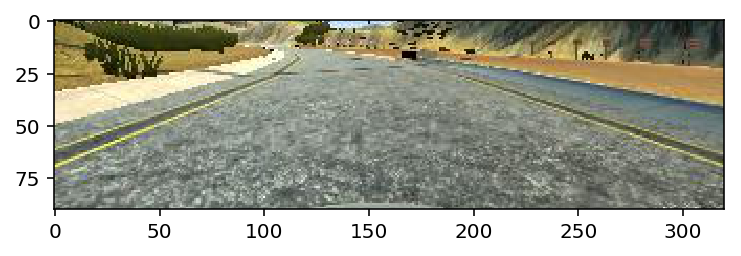

In [3]:
img = cv2.imread(df['center'][0])
print img.shape
img = img[50:-20,:]
plt.imshow(img[:,:,::-1])

In [4]:
n = len(df)
X = np.zeros((n, 160, 320, 3), dtype=np.uint8)
y = df['dir'].values

for i in tqdm(range(n)):
    X[i] = cv2.imread(df['center'][i])[:,:,::-1]


100%|██████████| 2587/2587 [00:02<00:00, 1280.03it/s]


In [5]:
X = np.concatenate([X, X[:,::-1]], axis=0)
y = np.concatenate([y, -y], axis=0)

In [6]:
from sklearn.utils import shuffle

X, y = shuffle(X, y)

In [7]:
inputs = Input(X.shape[1:])

x = inputs
x = Cropping2D(((50, 20), (0, 0)))(x)
x = Lambda(lambda x:x/255-0.5)(x)
for i in range(4):
    for j in range(2):
        x = Conv2D(32, 3, activation='relu')(x)
    x = MaxPooling2D(2)(x)

x = Flatten()(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.2)(x)
x = Dense(1, activation='tanh')(x)

model = Model(inputs, x)
model.compile(loss='mse', optimizer='adam')

In [8]:
# SVG(model_to_dot(model, show_shapes=True).create(prog='dot', format='svg'))

In [9]:
model.fit(X, y, batch_size=128, epochs=10, validation_split=0.2)

Train on 4139 samples, validate on 1035 samples
Epoch 1/10
4139/4139 [==============================] - 12s - loss: 0.0214 - val_loss: 0.0190
Epoch 2/10
4139/4139 [==============================] - 9s - loss: 0.0177 - val_loss: 0.0164
Epoch 3/10
4139/4139 [==============================] - 9s - loss: 0.0167 - val_loss: 0.0151
Epoch 4/10
4139/4139 [==============================] - 9s - loss: 0.0159 - val_loss: 0.0154
Epoch 5/10
4139/4139 [==============================] - 9s - loss: 0.0157 - val_loss: 0.0157
Epoch 6/10
4139/4139 [==============================] - 9s - loss: 0.0154 - val_loss: 0.0147
Epoch 7/10
4139/4139 [==============================] - 9s - loss: 0.0150 - val_loss: 0.0150
Epoch 8/10
4139/4139 [==============================] - 9s - loss: 0.0146 - val_loss: 0.0156
Epoch 9/10
4139/4139 [==============================] - 9s - loss: 0.0147 - val_loss: 0.0150
Epoch 10/10
4139/4139 [==============================] - 9s - loss: 0.0138 - val_loss: 0.0147


In [10]:
model.save('model.h5')

In [11]:
index = np.random.choice(n, 128)
y_pred = model.predict(X[index])[:,0]
print ((y_pred > 0) == (y[index] > 0)).mean()
list(zip(y_pred, y[index]))[:32]

0.65625


[(-0.036271568, 0.0),
 (-0.35503155, -0.28951759999999999),
 (-0.26965952, -0.20213989999999998),
 (-0.031996787, 0.0),
 (0.23563294, 0.20790909999999999),
 (-0.012585116, 0.0),
 (-0.012067248, -0.0),
 (-0.015557383, 0.0),
 (-0.012939082, -0.0),
 (0.13018143, 0.050751690000000002),
 (0.03002529, 0.0),
 (-0.046570901, -0.2365594),
 (0.06768433, 0.073334460000000004),
 (0.10851479, 0.39888240000000003),
 (0.14393397, -0.0),
 (0.11883179, -0.0),
 (0.027334174, 0.0),
 (-0.11511868, -0.28999190000000002),
 (0.010903982, -0.0),
 (-0.15840971, 0.0),
 (-0.023164863, 0.0),
 (-0.14252524, -0.11668540000000001),
 (0.019081248, -0.0),
 (0.11969114, 0.0),
 (-0.29076451, -0.20413049999999999),
 (0.13790406, 0.22381139999999999),
 (0.0089150881, -0.0),
 (-0.037245512, 0.0),
 (0.13383588, -0.0),
 (0.013823953, 0.0),
 (-0.095029138, 0.0),
 (0.063205935, -0.0)]